In [40]:
%matplotlib inline

import os
import StringIO
import time
import numpy
import pandas
import seaborn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from qumulo.rest_client import RestClient

In [41]:
rc = RestClient("<qumulo-cluster>", 8000)
rc.login("<qumulo-user>", "<qumulo-password>");

In [47]:
dir_depth = 1

act_types = [u'file-iops-read', u'file-iops-write', 
             u'file-throughput-read', u'file-throughput-write', 
             u'metadata-iops-read', u'metadata-iops-write',
             u'total-tput', u'total-iops']
activity_data = rc.analytics.current_activity_get()

ids = {}
for e in activity_data['entries']:
    ids[e['id']] = 1
ids = ids.keys()

id_path = {}
resolve_ids = []

print("Resolve %s paths" % len(ids))
while len(ids) > 0:
    resolve_ids.append(ids.pop())
    if len(resolve_ids) > 200 or len(ids) == 0:
        res = rc.fs.resolve_paths(resolve_ids)
        for d in res:
            id_path[d['id']] = d['path']
        resolve_ids = []

print("Create the data 'array'")
data = {}
for e in activity_data['entries']:
    if e['id'] in id_path:
        path = id_path[e['id']]
        path_parts = path.split("/")
        if len(path_parts) > 1:
            k = '/'.join(path_parts[:(1+dir_depth)]) + ':' + e['ip']
            if k not in data:
                data[k] = {}
                for t in act_types:
                    data[k][t] = 0
            data[k][e['type']] += e['rate']
            if 'throughput' in e['type']:
                data[k]['total-tput'] += e['rate']
            if 'iops' in e['type']:
                data[k]['total-iops'] += e['rate']


Resolve 1344 paths
Create the data 'array'


In [48]:
data_arr = []
for k, v in data.iteritems():
    (path, ip) = k.split(":")
    data_arr.append([path, ip, v['file-throughput-write'], v['file-iops-write'], v['file-throughput-read'], v['file-iops-read']])
df = pandas.DataFrame(data_arr, columns=['path', 'ip', 'write_tput', 'write_iops', 'read_tput', 'read_iops'])


In [55]:
dfp = pandas.pivot_table(df, index='path', columns='ip', values='read_iops', aggfunc=numpy.sum)

In [56]:
dfp

ip,10.116.201.105,10.120.247.91,10.120.247.92,10.120.247.95,10.20.217.62,127.0.0.1
path,,,,,,
/,0.0,0.0,0.0,NaN,0.0,0.0
/file-transfer-app,NaN,0.0,NaN,NaN,NaN,NaN
/music,NaN,NaN,NaN,NaN,0.0,NaN
/product-dsr,NaN,0.0,NaN,NaN,NaN,NaN
/query_db,0.0,NaN,NaN,18.75,NaN,NaN
/qumulo-historical-data,NaN,NaN,0.0,NaN,NaN,NaN
/releases_db,NaN,NaN,NaN,NaN,0.0,NaN
/test,0.0,NaN,NaN,NaN,NaN,NaN
/tv-shows,0.0,0.0,NaN,NaN,NaN,NaN


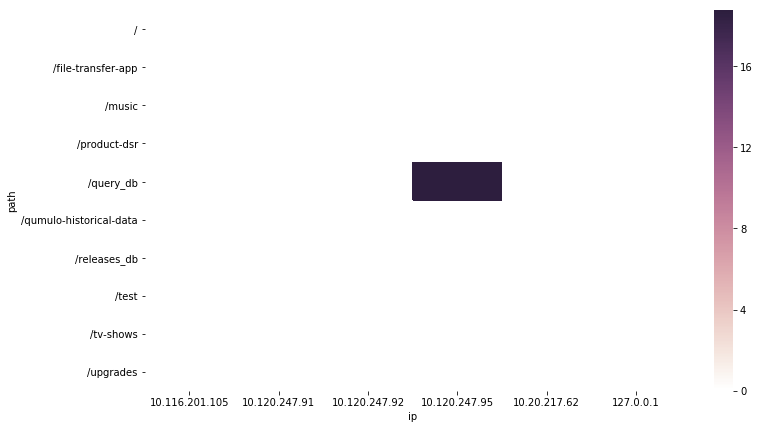

In [57]:
f, ax = plt.subplots(figsize=(12, 7))
cmap = seaborn.cubehelix_palette(light=1, as_cmap=True)
seaborn.heatmap(dfp, cmap=cmap)
